In [22]:
##################################################
# Imports
##################################################

import numpy as np
#import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import emoji
import seaborn as sns
sns.set_style("whitegrid")
from sklearn import preprocessing
from scipy.spatial import Voronoi
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import svm
import tensorflow as tf
from tensorflow import keras
from scipy.spatial import Voronoi, voronoi_plot_2d

##################################################
# Params
##################################################

DATA_BASE_FOLDER = '/kaggle/input/emojify-challenge'


##################################################
# Utils
##################################################

def label_to_emoji(label):
    """
    Converts a label (int or string) into the corresponding emoji code (string) ready to be printed
    """
    return emoji.emojize(emoji_dictionary[str(label)], use_aliases=True)

# Useful function

In [23]:
def accuracy(y_pred, y_true):
    '''
    input y_pred: ndarray of shape (N,)
    input y_true: ndarray of shape (N,)
    '''
    return (1.0 * (y_pred == y_true)).mean()

def plot_loss(history):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label = 'training')
    plt.xlabel('Epochs')
    plt.legend()
    plt.title('loss')

def plot_accuracy(history):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['accuracy'], label = 'training')
    plt.plot('Epochs')
    plt.legend()
    plt.title('accuracy')

In [24]:
##################################################
# Load dataset
##################################################

df_train = pd.read_csv('train.csv')
y_train = df_train['class']
df_validation = pd.read_csv('validation.csv')
y_validation = df_validation['class']
emoji_dictionary = {
    '0': '\u2764\uFE0F',
    '1': ':baseball:',
    '2': ':smile:',
    '3': ':disappointed:',
    '4': ':fork_and_knife:'
}

# See some data examples
print('EXAMPLES:\n####################')
for idx in range(10):
    print(f'{df_train["phrase"][idx]} -> {label_to_emoji(y_train[idx])}')

EXAMPLES:
####################
I want to go play -> ⚾
I want to have sushi for dinner -> 🍴
I am always working -> 😞
she is happy -> 😄
What is wrong with you -> 😞
I am proud of your achievements -> 😄
funny -> 😄
do you like pizza  -> 🍴
no one likes him -> 😞
he is the best player -> ⚾


In [25]:
print(emoji_dictionary)

{'0': '❤️', '1': ':baseball:', '2': ':smile:', '3': ':disappointed:', '4': ':fork_and_knife:'}


In [26]:
# Load phrase representation
x_train = np.load('train.npy').reshape(len(df_train), -1)
x_validation = np.load('validation.npy').reshape(len(df_validation), -1)
print(f'Word embedding size: {x_train.shape[-1]}')

Word embedding size: 250


Since we are going to apply the $k$-fold cross validation in order to tune the hyperparameters of our models, we merge training test and validation set into a single one.

In [27]:
### Joining training and validation set to perform k-fold cross validation ###

x_train_val = np.concatenate((x_train, x_validation))
y_train_val = np.concatenate((y_train, y_validation))
print(x_train_val.shape)

(132, 250)


In [28]:
### Normalizing dataset ###

scaler = preprocessing.StandardScaler()
x_train_val_norm = scaler.fit_transform(x_train_val)

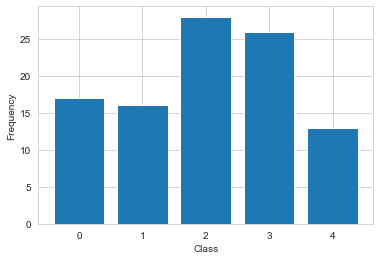

In [29]:
### Labels ditribution ###

df1=df_train.groupby(['class']).count()
plt.bar(df1.index,df1['phrase'])
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.savefig('Freq.png',bbox_inches='tight',dpi=300)

# Voronoi Diagram

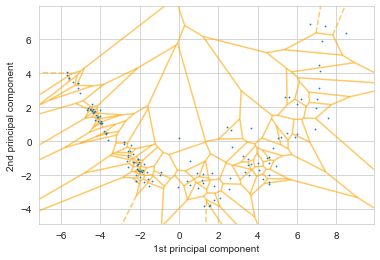

In [9]:
#VORONOI CON PCA & ORIGINAL DATA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(x_train_val)

vor = Voronoi(pca_result)
fig = voronoi_plot_2d(vor, show_vertices=False, line_colors='orange',line_width=1.5, line_alpha=0.6, point_size=1.5)
plt.xlabel("1st principal component")
plt.ylabel("2nd principal component")
#plt.savefig('vor_original_sk.png',bbox_inches='tight',dpi=300)
plt.show()

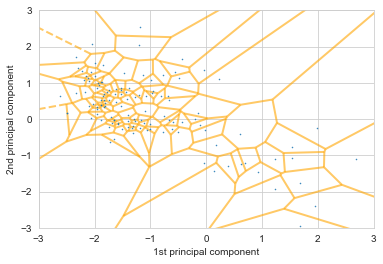

In [10]:
#VORONOI CON PCA & NORMALIZED DATA

pca_result = pca.fit_transform(x_train_val_norm)

vor = Voronoi(pca_result)
fig = voronoi_plot_2d(vor, show_vertices=False, line_colors='orange',line_width=2, line_alpha=0.6, point_size=1)
plt.xlabel("1st principal component")
plt.ylabel("2nd principal component")
plt.xlim(-3,3)
plt.ylim(-3,3)
#plt.savefig('vor_norm_sk.png',bbox_inches='tight',dpi=300)
plt.show()

# Logistic Regression Model


In [28]:
regressor = LogisticRegression(max_iter = 3000)
param_grid = {'solver' : ['newton-cg', 'saga', 'lbfgs', 'liblinear'], 
              'multi_class' : ['multinomial', 'ovr'], 
              'penalty': ['l2', 'l1'],
              'C' : [0.01, 0.1, 0.5, 1]}

regressor = GridSearchCV(regressor, param_grid, cv = 10, error_score=0.0)
regressor.fit(X=x_train_val_norm, y=y_train_val)
print('Best parameters:', regressor.best_params_)

y_train_pred = regressor.predict(x_train_val_norm)
print("Accuracy on the training set for regressor w/ grid:", accuracy(y_train_pred, y_train_val))

C:\Users\Al\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Al\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
C:\Users\Al\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Al\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
C:\Users\Al\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Al\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Searc

Best parameters: {'C': 0.1, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg'}
Accuracy on the training set for regressor w/ grid: 1.0


C:\Users\Al\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Al\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Al\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


## $k$-Nearest Neighbors

In [14]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 50),
              'metric': ['euclidean', 'manhattan','chebyshev']}
k_nn = GridSearchCV(knn, param_grid, cv=10)
k_nn.fit(x_train_val_norm, y_train_val)
print('best params:',k_nn.best_params_)

y_pred_train = k_nn.predict(x_train_val_norm)
k_nn_acc1 = accuracy(y_pred_train,y_train_val)
print("accuracy on training:",k_nn_acc1)

best params: {'metric': 'euclidean', 'n_neighbors': 1}
accuracy on training: 1.0


C:\Users\Al\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [29]:
x_train_val.shape

(132, 250)

## Linear Discriminant Analysis

In [15]:
lda = LinearDiscriminantAnalysis()

param_grid = {'solver': ['lsqr', 'eigen'], 'shrinkage': np.arange(0.1, 1, 0.1)}

lda_gscv = GridSearchCV(lda, param_grid, cv=10)
lda_gscv.fit(x_train_val_norm, y_train_val)
print('Best parameters:', lda_gscv.best_params_)

y_pred_train = lda_gscv.predict(x_train_val_norm)
lda_acc1 = accuracy(y_pred_train,y_train_val)
print("Accuracy on training:", lda_acc1)

Best parameters: {'shrinkage': 0.30000000000000004, 'solver': 'lsqr'}
Accuracy on training: 0.9924242424242424


C:\Users\Al\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## Support Vector Machines

In [16]:
svm2 = svm.LinearSVC(C=0.01, penalty='l2', tol=0.001, multi_class='ovr', random_state=123, max_iter=5000)
param_grid2 = {'C' : [0.001, 0.01, 0.5, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.7, 1]}

svm2_gscv = GridSearchCV(svm2, param_grid2, cv=10)
svm2_gscv.fit(x_train_val, y_train_val)
print('Best Parameters svm2:',svm2_gscv.best_params_)

y_pred_train_2 = svm2_gscv.predict(x_train_val)
print('Accuracy of svm2 on training set:', accuracy(y_pred_train_2, y_train_val))

Best Parameters svm2: {'C': 0.01}
Accuracy of svm2 on training set: 0.9393939393939394


C:\Users\Al\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## Neural Network

In [60]:
y_train_tf = pd.get_dummies(y_train)
y_valid_tf = pd.get_dummies(y_validation)
y_train_valid_tf = np.concatenate((y_train_tf, y_valid_tf))
x_train.shape

(100, 250)

In [54]:
tf.keras.backend.clear_session()

def def_model(n_units1 = 100, n_units2 = 50, reg1 = 0.001, reg2 = 0.001):
    
    X_input = tf.keras.Input(shape = (250,))
    
    X = tf.keras.layers.Dense(n_units1, kernel_regularizer=tf.keras.regularizers.l2(reg1), 
                              activation = 'tanh')(X_input) # di default questo comando comprende il bias term
    X = tf.keras.layers.Dense(n_units2, kernel_regularizer=tf.keras.regularizers.l2(reg2), 
                              activation = 'tanh')(X)
    X = tf.keras.layers.Dense(5, activation = 'softmax')(X)

    model = tf.keras.Model(inputs = X_input, outputs = X)
    
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model


#This gives you a Scikit-Learn compatible predictor
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(def_model)

In [55]:
# Grid search implementation
params_distrib = {'n_units1' : [40, 60, 80, 100], 
                  'reg1' : [0.001, 0.01], 
                  'n_units2' : [40, 50, 60],
                  'reg2' : [0.001, 0.01]}

grid_search = GridSearchCV(keras_reg, params_distrib, cv = 5)

grid_search.fit(x_train_val_norm, y_train_valid_tf, epochs = 10)

Epoch 1/10
4/4 [==============================] - 0s 2ms/step - loss: 1.9351 - accuracy: 0.1524
Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 1.6551 - accuracy: 0.3238
Epoch 3/10
4/4 [==============================] - 0s 3ms/step - loss: 1.4532 - accuracy: 0.4762
Epoch 4/10
4/4 [==============================] - 0s 5ms/step - loss: 1.2935 - accuracy: 0.5905
Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 1.1575 - accuracy: 0.7048
Epoch 6/10
4/4 [==============================] - 0s 4ms/step - loss: 1.0511 - accuracy: 0.7524
Epoch 7/10
4/4 [==============================] - 0s 4ms/step - loss: 0.9552 - accuracy: 0.7714
Epoch 8/10
4/4 [==============================] - 0s 3ms/step - loss: 0.8737 - accuracy: 0.8095
Epoch 9/10
4/4 [==============================] - 0s 4ms/step - loss: 0.8009 - accuracy: 0.8571
Epoch 10/10
1/1 [==============================] - 0s 1ms/step - loss: 1.4671 - accuracy: 0.3704
Epoch 1/10
4/4 [=======================

GridSearchCV(cv=5, error_score=nan,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7feb00ad53d0>,
             iid='deprecated', n_jobs=None,
             param_grid={'n_units1': [40, 60, 80, 100],
                         'n_units2': [40, 50, 60], 'reg1': [0.001, 0.01],
                         'reg2': [0.001, 0.01]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [56]:
print(grid_search.best_params_)

model = grid_search.best_estimator_.model

model_accuracy = model.evaluate(x_train_val_norm, y_train_valid_tf)

print()
print("Accuracy on the training set of the neural network:", model_accuracy[1])


{'n_units1': 60, 'n_units2': 60, 'reg1': 0.001, 'reg2': 0.001}
5/5 [==============================] - 0s 3ms/step - loss: 0.4797 - accuracy: 0.9697

Accuracy on the training set of the neural network: 0.9696969985961914


In [57]:
plot_loss(model.history)

plot_accuracy(model.history)

KeyError: 'loss'

<Figure size 720x432 with 0 Axes>

In [58]:
df_test = pd.read_csv('test_manual.csv')
y_test = df_test['class']
#print(df_test)
# Load phrase representation
x_test = np.load('test.npy').reshape(len(df_test), -1)
print(f'Word embedding size: {x_train.shape[-1]}')
### SCALING THE TEST SET ###
x_test_norm = scaler.fit_transform(x_test)

Word embedding size: 250


In [59]:

y_test_pred = np.argmax(model.predict(x_test), axis = 1)

deep_test_accuracy = accuracy(y_test_pred, y_test)
#model_accuracy = model.evaluate(, y_train_valid_tf)
print("Deep model accuracy on the test set:", deep_test_accuracy)

y_test_pred = np.argmax(model.predict(x_test_norm), axis = 1)
deep_test_accuracy = accuracy(y_test_pred, y_test)

print("Deep model accuracy on the norm test set:", deep_test_accuracy)

Deep model accuracy on the test set: 0.3392857142857143
Deep model accuracy on the norm test set: 0.5892857142857143


### OFFICIAL SUBMISSION


In [27]:
#################################################
# Save your test prediction in y_test_pred
##################################################

y_test_pred = None

# Create submission
submission = pd.read_csv('log_reg_norm.csv')
x_test = np.load('test.npy').reshape(len(submission), -1)
x_test_norm = scaler.fit_transform(x_test)

y_test_pred = np.argmax(model.predict(x_test), axis = 1)
if y_test_pred is not None:
    submission['class'] = y_test_pred
submission.to_csv('deep_model_norm.csv', index=False)